In [1]:
import os
import gdown
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import r2_score
def download_training_data(id_file, output_folder, output_name):
    url = f"https://drive.google.com/uc?id={id_file}"
    os.makedirs(output_folder, exist_ok=True)
    gdown.download(url, output_folder + output_name, quiet=False)
    
def load_data(input_folder, input_name):
    df = pd.read_feather(input_folder + input_name)
    df["target_10_multiplied"] = df["target_10"]*1000
    # training, test, validation
    return df[df.type=="training"], df[df.type=="validation"], df[df.type=="validation_unseen"]

In [2]:
file, folder = "training_all_crypto.feather", "temp/"

In [3]:
# Download data

download_training_data("15VkzDb8sfWTDOl44ODmkNS20KEszWUb-", folder, file)

Downloading...
From: https://drive.google.com/uc?id=15VkzDb8sfWTDOl44ODmkNS20KEszWUb-
To: /Users/pablocanadapereira/Desktop/Projects/trading/trading/notebooks/temp/training_all_crypto.feather
100%|██████████| 398M/398M [00:09<00:00, 41.2MB/s] 


In [4]:
df_training, df_val, df_val_unseen = load_data(folder, file)
columns_features = [col for col in df_training.columns if col.startswith("feature")]
#columns_target = [col for col in df_training.columns if col.startswith("target")]
columns_target = ["target_10_multiplied"]

In [121]:
df_training_optuna = df_training.sample(10000)

In [122]:

def objective(trial):
    # 1. Suggest values of the hyperparameters using a trial object.
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1,100, log=True),
        "max_depth": trial.suggest_int("max_depth", 2,20),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001,0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5,1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0,1),
    }

    # 2. Define model
    model =xgb.XGBRegressor(**param,
    n_jobs=-1,
    )
    # 3. Train
    model.fit(df_training_optuna[columns_features].astype("float32"), df_training_optuna[columns_target].astype("float32"))
    # 4. Evaluate
    df_val_eval = pd.DataFrame(index=df_val.index)
    df_val_eval["target"] = df_val[columns_target]
    df_val_eval["preds"] = model.predict(df_val[columns_features])
    #data={"target": df_val[columns_target].values], "preds": [model.predict(df_val[columns_features])]})
    corr_val = df_val_eval.corr().values[0][1]
    r2 = r2_score(df_val_eval.target, df_val_eval.preds )
    metric = 0.2*corr_val + 0.8*r2
    print(trial.number)
    print("Corr and r2: ",corr_val, r2)
    print("Metric: ", metric)
    return metric

# 3. Create a study object and optimize the objective function.
optuna.logging.set_verbosity("ERROR")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

0
Corr and r2:  0.1473918482705983 -0.006266001548521416
Metric:  0.024465568415302532
1
Corr and r2:  0.08930330508853832 -0.006446767473959891
Metric:  0.012703247038539752
2
Corr and r2:  0.15885258418768022 -0.004915407032159758
Metric:  0.02783819121180824
3
Corr and r2:  0.07257488009491295 0.002605621874685493
Metric:  0.016599473518730985
4
Corr and r2:  0.09690026609837572 -0.05145146085460128
Metric:  -0.02178111546400588
5
Corr and r2:  0.11472668136677557 -0.006394324614395819
Metric:  0.017829876581838457
[18:45:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


6
Corr an

In [ ]:
optuna.importance.get_param_importances(study)

# Train final model and check

In [74]:
test_size = 10000

In [51]:
from src.core.features.utils import feature_pipeline, add_domain_features
import matplotlib.pyplot as plt

In [52]:
best_params = {'booster': 'gblinear',
 'lambda': 1.0316183369767604e-08,
 'alpha': 5.146496638539848e-05,
 'n_estimators': 4,
 'max_depth': 3}

In [125]:
best_params = study.best_trial.params
print(best_params)

{'booster': 'dart', 'lambda': 0.00014989237397099598, 'alpha': 2.903850614351889e-08, 'n_estimators': 62, 'max_depth': 16, 'learning_rate': 0.03599046129318702, 'subsample': 0.6275290090011264, 'colsample_bytree': 0.08148102468342494}


In [76]:
# double check
df_training_sampled = df_training.iloc[:-test_size]
df_test_init = df_training.iloc[-test_size:][["open", "high", "low", "close", "vwap", "volume"]]

In [77]:
df_test, _=feature_pipeline(df_test_init, include_target=False)

In [56]:
#compute_RSI(df_test_init, "open", 100) # it is not
#add_domain_features(df_test_init, "open").iloc[-1:].isnull().sum()


In [60]:
#df_test

In [59]:
#df_test_init

In [61]:
#df_test[columns_features].columns

In [62]:
#df_training_sampled

In [ ]:
final_model =xgb.XGBRegressor(**best_params,
    n_jobs=-1,
    )
final_model.fit(df_training_sampled[columns_features].astype("float32"), df_training_sampled[columns_target].astype("float32"))

In [ ]:
plt.figure(figsize=(15,5))
preds = final_model.predict(df_test[columns_features])
target = df_training.iloc[-(test_size-400):].reset_index()["target_10"]*1000
plt.plot(preds*10, label="preds")
plt.plot(target, label="target")
plt.xlim([0,1000])
plt.legend()
plt.show()
print(pd.DataFrame(data={"preds": preds, "target": target}).corr().values[0][1])
print(r2_score(target,preds ))

In [27]:
df_plot_test = get_df_plot(df_val, final_model, pytorch=False)
plot_results(df_plot_test)

NameError: name 'get_df_plot' is not defined

In [38]:
final_model =xgb.XGBRegressor(**study.best_trial.params,
    learning_rate=0.1,
    n_jobs=-1,
    subsample=0.9,
    colsample_bytree=0.1,
    )
    # 3. Train
final_model.fit(df_training[columns_features].astype("float32"), df_training[columns_target].astype("float32"))

[19:35:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=5.146496638539848e-05, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             lambda=1.0316183369767604e-08, learning_rate=0.1,
             max_delta_step=None, max_depth=3, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=4, n_jobs=-1,
             num_parallel_tree=None, random_state=0, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=0.9, tree_method=None,
             validate_parameters=1, verbosity=None)

In [14]:
def get_df_plot(df, model, pytorch=True):
    df_plot = df.reset_index()[columns_target].rename(columns={columns_target[0]:"target"})
    if pytorch:
        df_plot["preds"] = model.predict(df, columns_features, cpu_dev)
    else:
        df_plot["preds"] = model.predict(df[columns_features])
                                    
    return df_plot
def plot_results(df, xlim=None):
    fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [3, 1]})
    axs[0].plot(df["preds"], label="preds")
    axs[0].plot(df["target"],label= "target", alpha=0.5)
    if xlim:
        axs[0].set_xlim(xlim)
    axs[0].legend()
    axs[1].plot(df.preds, df.target, "o", alpha=0.5)
    print("corr: ", df.corr().values[0][1])
    print("r2: ", r2_score(df.target,df.preds ))

In [47]:
df_plot_val = get_df_plot(df_val, final_model, pytorch=False)
df_plot_val_unseen = get_df_plot(df_val_unseen, final_model, pytorch=False)


corr:  0.30000491070842966
r2:  0.08820782881052547


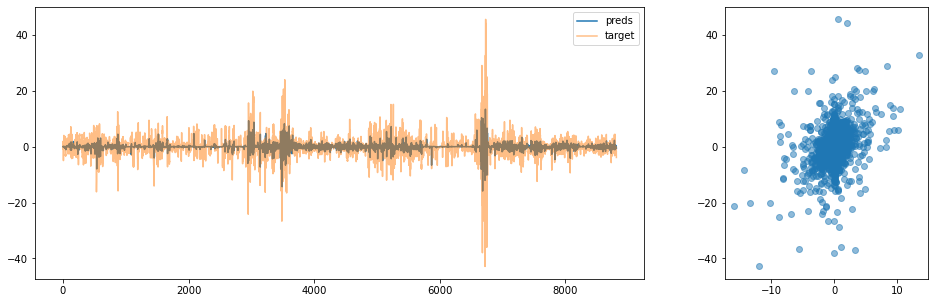

In [48]:
plot_results(df_plot_val)

corr:  0.34681178644103405
r2:  0.10764870659901982


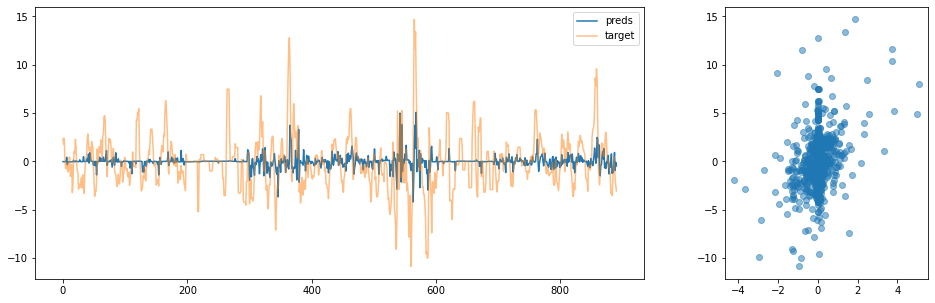

In [49]:
plot_results(df_plot_val_unseen)

In [ ]:
plot_results(df_plot_val_unseen, xlim=[100,1000])

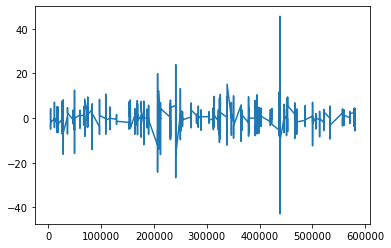

In [39]:
import matplotlib.pyplot as plt
df_plot_val = get_df_plot(df_validation, model, pytorch=False)